# 🤔 Topic Modeling on Paper Titles

## 💾 Loading Data

In [108]:
# Displaying full output in Jupyter, not only the last result:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd

# Load the dataset into a pandas DataFrame
df = pd.read_csv("chatgpt_articles.csv")
df.head()


,Title,Link,Snippet,Citations,Puplication Information
0,ChatGPT and the Rise of Large Language Models:...,https://papers.ssrn.com/sol3/papers.cfm?abstra...,… a product generated by ChatGPT would be … Ch...,Save Cite Cited by 8,"L De Angelis, F Baglivo, G Arzilli… - Availabl..."
1,ChatGPT-Reshaping medical education and clinic...,https://www.pjms.org.pk/index.php/pjms/article...,… ChatGPT is the most widely known of the list...,Save Cite Cited by 4 All 6 versions View as H...,"RA Khan, M Jawaid, AR Khan, M Sajjad - Pakista..."
2,Collaborating With ChatGPT: Considering the Im...,https://journals.sagepub.com/doi/abs/10.1177/1...,… platform called ChatGPT made available to th...,Save Cite Cited by 37 Related articles,JV Pavlik - Journalism & Mass Communication Ed...
3,A prompt pattern catalog to enhance prompt eng...,https://arxiv.org/abs/2302.11382,… prompts were tested with ChatGPT [12] using ...,Save Cite Cited by 4 All 3 versions View as H...,"J White, Q Fu, S Hays, M Sandborn, C Olea… - a..."
4,Exploring the limits of chatgpt for query or a...,https://arxiv.org/abs/2302.08081,… ChatGPT-generated summaries and human refere...,Save Cite Cited by 4 All 2 versions View as H...,"X Yang, Y Li, X Zhang, H Chen, W Cheng - arXiv..."


In [109]:
df["Title"] = df["Title"].astype(str)


titles = df['Title'].to_list()


print("The first article title in the dataset📝:\n")
print(titles[0])


The first article title in the dataset📝:

ChatGPT and the Rise of Large Language Models: The New AI-Driven Infodemic Threat in Public Health


## 🧹 Data Preprocessing

In [110]:
# Data Cleaning:
import string
import re
from langdetect import detect #to get rid of non-english titles
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
from nltk.corpus import words #we can also use words.words() method to get rid of non-english articles
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from gensim.utils import simple_preprocess

#Visualization:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Topic Modeling:
import gensim
# simple_process tokenizes a piece of text into individual words and removes any punctuation marks
from gensim.utils import simple_preprocess
#to work with textual data:
import gensim.corpora as corpora 
# if you don't want to write the preprocessing code:
# from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
# to visualize lda models in python:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

print("Successully imported all libraries.")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samaneh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to /Users/samaneh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package words to /Users/samaneh/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

Successully imported all libraries.


In [111]:
# perform preprocessing and data cleaning on the article titles

stop_words = stopwords.words('english')
custom_stop_words = ['chatgpt', 'html']
stop_words = stop_words + custom_stop_words
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english') #we decided not to use it
 
    
def lemmatize(text):
    return WordNetLemmatizer().lemmatize(text, pos='v')


def preprocess(text):
    # text = re.sub('^\[.*?\]\s*', '', text) #remove [...][...] from the beginning of titiles
    text = text.replace('\n', '') #remove \n from snippets
    text = text.replace('\r', '') #remove \r from snippets
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = text.lower()  # convert to lowercase
    tokens = text.split()
    
    result = []
    for token in simple_preprocess(text):
        if token not in stop_words and len(token) > 3:
            # result.append(lemmatize_stemming(token))
            result.append(lemmatize(token))
            
    return result


english_titles = [title for title in titles if detect(title)=='en']


cleaned_titles = [preprocess(title) for title in english_titles]


print('Number of All Papers in the dataset:', len(titles))
print("\n")
print("Number of Non-English Papers:", len(english_titles))
print("\n")
print("First Article Title in the Dataset:",titles[0])
print("\n")
print("Cleaned Version:",cleaned_titles[0])

Number of All Papers in the dataset: 925


Number of Non-English Papers: 822


First Article Title in the Dataset: ChatGPT and the Rise of Large Language Models: The New AI-Driven Infodemic Threat in Public Health


Cleaned Version: ['rise', 'large', 'language', 'model', 'aidriven', 'infodemic', 'threat', 'public', 'health']


## 💡 Creating LDA Topic Model

In [112]:
# create a dictionary
id2word = corpora.Dictionary(cleaned_titles)
# create a BoW
corpus = [id2word.doc2bow(cleaned_title) for cleaned_title in cleaned_titles]

### Finding the Optimal Number of Topics

##### The approach to finding the optimal number of topics is to build many LDA models with different values of a number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of the rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics. If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

In [8]:
def compute_coherence_values(dictionary, corpus, texts, limit, start =2, step=1):
    
    """
    compute c_v coherence for various number of topics
    
    parameters:
    -----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input texts
    limit: max num of topics
    
    
    returns:
    --------
    model_list: list of LDA topic models
    coherence values: coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, limit,step):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, num_topics = num_topics, random_state = 100, 
                                               chunksize = 200, passes =10, per_word_topics = True, id2word = id2word)
        
        model_list.append(model)
        coherencemodel1 = CoherenceModel(model= model, texts= texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel1.get_coherence())
        
        
    return model_list, coherence_values
    
    

#### Creating 10 LDA models with different number of topics and get the coherence value for each topic model


In [9]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus = corpus, texts = cleaned_titles, start=2, limit = 10, step = 1)
                                                                                        


#### Visualizing the coherence score for different number of topics

Text(0.5, 0, 'Number of Topics')

Text(0, 0.5, 'Coherence Score')

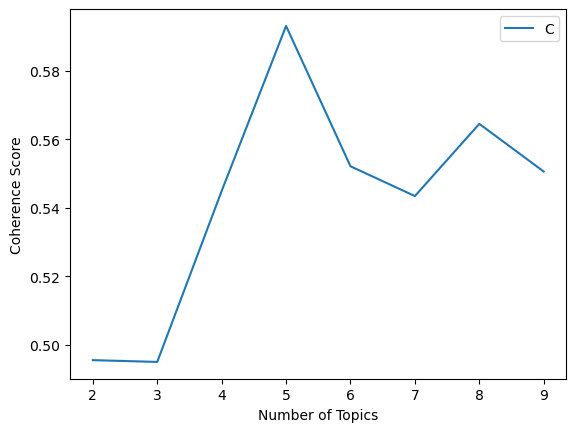

In [10]:
# show graph

limit = 10
start = 2
step = 1

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence_Values"), loc = 'best')
plt.show()

In [11]:
# print the coherence scores

for m, cv in zip(x,coherence_values):
    print("Number of Topics =", m, " has Coherence Value of", round(cv,4))

Number of Topics = 2  has Coherence Value of 0.4956
Number of Topics = 3  has Coherence Value of 0.495
Number of Topics = 4  has Coherence Value of 0.5449
Number of Topics = 5  has Coherence Value of 0.593
Number of Topics = 6  has Coherence Value of 0.5521
Number of Topics = 7  has Coherence Value of 0.5434
Number of Topics = 8  has Coherence Value of 0.5645
Number of Topics = 9  has Coherence Value of 0.5506


#### Other hyperparameters:

Hyperparameter alpha: Document-Topic Density
<br>
Hyperparameter beta: Word-Topic Density
<br>
High α means every document is likely to contain a mixture of most of the topics and not just any single topic specifically.
<br>
Low α means A document is more likely to be represented by just a few of the topics.
<br>
β : Per topic word distribution
<br>
High β means each topic is likely to contain a mixture of most of the words not just any word specifically.
<br>
Low β means the topic may contain a mixture of just a few words.</h4>

In [12]:
# supporting function
def compute_coherence_vals(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=5,
                                               random_state=100,
                                               chunksize=200,
                                               passes=10,
                                               alpha=a,
                                               eta=b,
                                               per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=cleaned_titles, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()
    
    
    

In [13]:
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 10
step_size = 1
topics_range = range(min_topics,max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01,1,0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

In [14]:
# Validation sets

num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), corpus]

corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                'Topics': [],
                'Alpha': [],
                'Beta': [],
                'Coherence': []
                }

if 1 ==1:
    pbar = tqdm.tqdm(total = 540)
    
    for i in range(len(corpus_sets)):
        #iterate through number of topics
        for k in topics_range:
            #iterate through alpha values
            for a in alpha:
                #iterate through beta values
                for b in beta:
                    #get the coherence score for the given parameters
                    cv = compute_coherence_vals(corpus=corpus_sets[i], dictionary=id2word,
                                               k=k, a=a, b=b)
                    
                    
                    #save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_turning_results.csv', index=False)
    pbar.close()


  0%|                                           | 1/540 [00:02<22:26,  2.50s/it]

True

  0%|▏                                          | 2/540 [00:04<22:20,  2.49s/it]

True

  1%|▏                                          | 3/540 [00:07<22:41,  2.54s/it]

True

  1%|▎                                          | 4/540 [00:10<22:57,  2.57s/it]

True

  1%|▍                                          | 5/540 [00:12<22:35,  2.53s/it]

True

  1%|▍                                          | 6/540 [00:15<22:25,  2.52s/it]

True

  1%|▌                                          | 7/540 [00:17<22:52,  2.58s/it]

True

  1%|▋                                          | 8/540 [00:20<23:18,  2.63s/it]

True

  2%|▋                                          | 9/540 [00:23<23:59,  2.71s/it]

True

  2%|▊                                         | 10/540 [00:25<23:23,  2.65s/it]

True

  2%|▊                                         | 11/540 [00:28<22:26,  2.55s/it]

True

  2%|▉                                         | 12/540 [00:30<22:30,  2.56s/it]

True

  2%|█                                         | 13/540 [00:33<22:51,  2.60s/it]

True

  3%|█                                         | 14/540 [00:36<23:22,  2.67s/it]

True

  3%|█▏                                        | 15/540 [00:38<22:49,  2.61s/it]

True

  3%|█▏                                        | 16/540 [00:41<22:06,  2.53s/it]

True

  3%|█▎                                        | 17/540 [00:43<22:01,  2.53s/it]

True

  3%|█▍                                        | 18/540 [00:46<22:10,  2.55s/it]

True

  4%|█▍                                        | 19/540 [00:49<22:29,  2.59s/it]

True

  4%|█▌                                        | 20/540 [00:51<22:07,  2.55s/it]

True

  4%|█▋                                        | 21/540 [00:53<21:46,  2.52s/it]

True

  4%|█▋                                        | 22/540 [00:56<21:49,  2.53s/it]

True

  4%|█▊                                        | 23/540 [00:59<22:14,  2.58s/it]

True

  4%|█▊                                        | 24/540 [01:01<22:41,  2.64s/it]

True

  5%|█▉                                        | 25/540 [01:04<22:23,  2.61s/it]

True

  5%|██                                        | 26/540 [01:07<22:06,  2.58s/it]

True

  5%|██                                        | 27/540 [01:09<21:57,  2.57s/it]

True

  5%|██▏                                       | 28/540 [01:12<22:11,  2.60s/it]

True

  5%|██▎                                       | 29/540 [01:14<22:31,  2.64s/it]

True

  6%|██▎                                       | 30/540 [01:17<22:12,  2.61s/it]

True

  6%|██▍                                       | 31/540 [01:19<21:41,  2.56s/it]

True

  6%|██▍                                       | 32/540 [01:22<21:41,  2.56s/it]

True

  6%|██▌                                       | 33/540 [01:25<21:49,  2.58s/it]

True

  6%|██▋                                       | 34/540 [01:27<22:05,  2.62s/it]

True

  6%|██▋                                       | 35/540 [01:30<21:56,  2.61s/it]

True

  7%|██▊                                       | 36/540 [01:33<21:54,  2.61s/it]

True

  7%|██▉                                       | 37/540 [01:35<22:12,  2.65s/it]

True

  7%|██▉                                       | 38/540 [01:38<22:49,  2.73s/it]

True

  7%|███                                       | 39/540 [01:41<23:40,  2.83s/it]

True

  7%|███                                       | 40/540 [01:44<23:17,  2.80s/it]

True

  8%|███▏                                      | 41/540 [01:47<22:35,  2.72s/it]

True

  8%|███▎                                      | 42/540 [01:49<22:37,  2.73s/it]

True

  8%|███▎                                      | 43/540 [01:52<23:02,  2.78s/it]

True

  8%|███▍                                      | 44/540 [01:55<23:33,  2.85s/it]

True

  8%|███▌                                      | 45/540 [01:58<23:01,  2.79s/it]

True

  9%|███▌                                      | 46/540 [02:00<22:25,  2.72s/it]

True

  9%|███▋                                      | 47/540 [02:03<22:15,  2.71s/it]

True

  9%|███▋                                      | 48/540 [02:06<22:31,  2.75s/it]

True

  9%|███▊                                      | 49/540 [02:09<22:49,  2.79s/it]

True

  9%|███▉                                      | 50/540 [02:11<22:31,  2.76s/it]

True

  9%|███▉                                      | 51/540 [02:14<22:19,  2.74s/it]

True

 10%|████                                      | 52/540 [02:17<22:18,  2.74s/it]

True

 10%|████                                      | 53/540 [02:20<22:35,  2.78s/it]

True

 10%|████▏                                     | 54/540 [02:23<22:49,  2.82s/it]

True

 10%|████▎                                     | 55/540 [02:25<22:30,  2.78s/it]

True

 10%|████▎                                     | 56/540 [02:28<21:57,  2.72s/it]

True

 11%|████▍                                     | 57/540 [02:31<21:48,  2.71s/it]

True

 11%|████▌                                     | 58/540 [02:33<22:01,  2.74s/it]

True

 11%|████▌                                     | 59/540 [02:36<22:22,  2.79s/it]

True

 11%|████▋                                     | 60/540 [02:39<22:03,  2.76s/it]

True

 11%|████▋                                     | 61/540 [02:42<21:41,  2.72s/it]

True

 11%|████▊                                     | 62/540 [02:44<21:37,  2.71s/it]

True

 12%|████▉                                     | 63/540 [02:47<21:46,  2.74s/it]

True

 12%|████▉                                     | 64/540 [02:50<21:59,  2.77s/it]

True

 12%|█████                                     | 65/540 [02:53<21:38,  2.73s/it]

True

 12%|█████▏                                    | 66/540 [02:55<21:31,  2.72s/it]

True

 12%|█████▏                                    | 67/540 [02:58<21:49,  2.77s/it]

True

 13%|█████▎                                    | 68/540 [03:01<22:11,  2.82s/it]

True

 13%|█████▎                                    | 69/540 [03:04<22:42,  2.89s/it]

True

 13%|█████▍                                    | 70/540 [03:07<22:30,  2.87s/it]

True

 13%|█████▌                                    | 71/540 [03:10<21:45,  2.78s/it]

True

 13%|█████▌                                    | 72/540 [03:12<21:42,  2.78s/it]

True

 14%|█████▋                                    | 73/540 [03:15<22:06,  2.84s/it]

True

 14%|█████▊                                    | 74/540 [03:18<22:34,  2.91s/it]

True

 14%|█████▊                                    | 75/540 [03:21<22:04,  2.85s/it]

True

 14%|█████▉                                    | 76/540 [03:24<21:26,  2.77s/it]

True

 14%|█████▉                                    | 77/540 [03:27<21:26,  2.78s/it]

True

 14%|██████                                    | 78/540 [03:30<21:50,  2.84s/it]

True

 15%|██████▏                                   | 79/540 [03:33<22:08,  2.88s/it]

True

 15%|██████▏                                   | 80/540 [03:35<21:46,  2.84s/it]

True

 15%|██████▎                                   | 81/540 [03:38<21:20,  2.79s/it]

True

 15%|██████▍                                   | 82/540 [03:41<21:20,  2.80s/it]

True

 15%|██████▍                                   | 83/540 [03:44<21:34,  2.83s/it]

True

 16%|██████▌                                   | 84/540 [03:47<21:48,  2.87s/it]

True

 16%|██████▌                                   | 85/540 [03:49<21:27,  2.83s/it]

True

 16%|██████▋                                   | 86/540 [03:52<21:05,  2.79s/it]

True

 16%|██████▊                                   | 87/540 [03:55<21:01,  2.79s/it]

True

 16%|██████▊                                   | 88/540 [03:58<21:08,  2.81s/it]

True

 16%|██████▉                                   | 89/540 [04:01<21:24,  2.85s/it]

True

 17%|███████                                   | 90/540 [04:03<21:00,  2.80s/it]

True

 17%|███████                                   | 91/540 [04:06<20:35,  2.75s/it]

True

 17%|███████▏                                  | 92/540 [04:09<20:36,  2.76s/it]

True

 17%|███████▏                                  | 93/540 [04:12<20:37,  2.77s/it]

True

 17%|███████▎                                  | 94/540 [04:14<20:43,  2.79s/it]

True

 18%|███████▍                                  | 95/540 [04:17<20:24,  2.75s/it]

True

 18%|███████▍                                  | 96/540 [04:20<20:16,  2.74s/it]

True

 18%|███████▌                                  | 97/540 [04:23<20:27,  2.77s/it]

True

 18%|███████▌                                  | 98/540 [04:26<21:01,  2.85s/it]

True

 18%|███████▋                                  | 99/540 [04:29<21:40,  2.95s/it]

True

 19%|███████▌                                 | 100/540 [04:32<21:19,  2.91s/it]

True

 19%|███████▋                                 | 101/540 [04:34<20:40,  2.83s/it]

True

 19%|███████▋                                 | 102/540 [04:37<20:37,  2.83s/it]

True

 19%|███████▊                                 | 103/540 [04:40<21:01,  2.89s/it]

True

 19%|███████▉                                 | 104/540 [04:43<21:37,  2.98s/it]

True

 19%|███████▉                                 | 105/540 [04:46<21:12,  2.92s/it]

True

 20%|████████                                 | 106/540 [04:49<20:29,  2.83s/it]

True

 20%|████████                                 | 107/540 [04:52<20:19,  2.82s/it]

True

 20%|████████▏                                | 108/540 [04:54<20:27,  2.84s/it]

True

 20%|████████▎                                | 109/540 [04:57<20:40,  2.88s/it]

True

 20%|████████▎                                | 110/540 [05:00<20:26,  2.85s/it]

True

 21%|████████▍                                | 111/540 [05:03<20:01,  2.80s/it]

True

 21%|████████▌                                | 112/540 [05:06<20:05,  2.82s/it]

True

 21%|████████▌                                | 113/540 [05:09<20:24,  2.87s/it]

True

 21%|████████▋                                | 114/540 [05:12<20:44,  2.92s/it]

True

 21%|████████▋                                | 115/540 [05:14<20:19,  2.87s/it]

True

 21%|████████▊                                | 116/540 [05:17<19:56,  2.82s/it]

True

 22%|████████▉                                | 117/540 [05:20<19:45,  2.80s/it]

True

 22%|████████▉                                | 118/540 [05:23<19:52,  2.83s/it]

True

 22%|█████████                                | 119/540 [05:26<20:01,  2.86s/it]

True

 22%|█████████                                | 120/540 [05:28<19:43,  2.82s/it]

True

 22%|█████████▏                               | 121/540 [05:31<19:19,  2.77s/it]

True

 23%|█████████▎                               | 122/540 [05:34<19:20,  2.78s/it]

True

 23%|█████████▎                               | 123/540 [05:37<19:26,  2.80s/it]

True

 23%|█████████▍                               | 124/540 [05:40<19:30,  2.81s/it]

True

 23%|█████████▍                               | 125/540 [05:42<19:22,  2.80s/it]

True

 23%|█████████▌                               | 126/540 [05:45<19:16,  2.79s/it]

True

 24%|█████████▋                               | 127/540 [05:48<19:24,  2.82s/it]

True

 24%|█████████▋                               | 128/540 [05:51<19:48,  2.89s/it]

True

 24%|█████████▊                               | 129/540 [05:54<20:21,  2.97s/it]

True

 24%|█████████▊                               | 130/540 [05:57<20:07,  2.95s/it]

True

 24%|█████████▉                               | 131/540 [06:00<19:32,  2.87s/it]

True

 24%|██████████                               | 132/540 [06:03<19:32,  2.87s/it]

True

 25%|██████████                               | 133/540 [06:06<19:52,  2.93s/it]

True

 25%|██████████▏                              | 134/540 [06:09<20:11,  2.98s/it]

True

 25%|██████████▎                              | 135/540 [06:12<19:47,  2.93s/it]

True

 25%|██████████▎                              | 136/540 [06:14<19:07,  2.84s/it]

True

 25%|██████████▍                              | 137/540 [06:17<19:04,  2.84s/it]

True

 26%|██████████▍                              | 138/540 [06:20<19:13,  2.87s/it]

True

 26%|██████████▌                              | 139/540 [06:23<19:21,  2.90s/it]

True

 26%|██████████▋                              | 140/540 [06:26<19:05,  2.86s/it]

True

 26%|██████████▋                              | 141/540 [06:29<18:48,  2.83s/it]

True

 26%|██████████▊                              | 142/540 [06:31<18:47,  2.83s/it]

True

 26%|██████████▊                              | 143/540 [06:34<19:03,  2.88s/it]

True

 27%|██████████▉                              | 144/540 [06:38<19:28,  2.95s/it]

True

 27%|███████████                              | 145/540 [06:40<19:08,  2.91s/it]

True

 27%|███████████                              | 146/540 [06:43<18:44,  2.86s/it]

True

 27%|███████████▏                             | 147/540 [06:46<18:48,  2.87s/it]

True

 27%|███████████▏                             | 148/540 [06:49<19:06,  2.92s/it]

True

 28%|███████████▎                             | 149/540 [06:52<19:09,  2.94s/it]

True

 28%|███████████▍                             | 150/540 [06:55<18:47,  2.89s/it]

True

 28%|███████████▍                             | 151/540 [06:58<18:50,  2.91s/it]

True

 28%|███████████▌                             | 152/540 [07:01<18:52,  2.92s/it]

True

 28%|███████████▌                             | 153/540 [07:04<19:01,  2.95s/it]

True

 29%|███████████▋                             | 154/540 [07:07<19:12,  2.99s/it]

True

 29%|███████████▊                             | 155/540 [07:10<18:49,  2.93s/it]

True

 29%|███████████▊                             | 156/540 [07:12<18:34,  2.90s/it]

True

 29%|███████████▉                             | 157/540 [07:15<18:44,  2.94s/it]

True

 29%|███████████▉                             | 158/540 [07:19<19:09,  3.01s/it]

True

 29%|████████████                             | 159/540 [07:22<19:36,  3.09s/it]

True

 30%|████████████▏                            | 160/540 [07:25<19:16,  3.04s/it]

True

 30%|████████████▏                            | 161/540 [07:28<18:37,  2.95s/it]

True

 30%|████████████▎                            | 162/540 [07:31<18:42,  2.97s/it]

True

 30%|████████████▍                            | 163/540 [07:34<18:51,  3.00s/it]

True

 30%|████████████▍                            | 164/540 [07:37<19:21,  3.09s/it]

True

 31%|████████████▌                            | 165/540 [07:40<18:55,  3.03s/it]

True

 31%|████████████▌                            | 166/540 [07:43<18:11,  2.92s/it]

True

 31%|████████████▋                            | 167/540 [07:45<18:02,  2.90s/it]

True

 31%|████████████▊                            | 168/540 [07:48<18:14,  2.94s/it]

True

 31%|████████████▊                            | 169/540 [07:51<18:22,  2.97s/it]

True

 31%|████████████▉                            | 170/540 [07:54<17:57,  2.91s/it]

True

 32%|████████████▉                            | 171/540 [07:57<17:36,  2.86s/it]

True

 32%|█████████████                            | 172/540 [08:00<17:42,  2.89s/it]

True

 32%|█████████████▏                           | 173/540 [08:03<17:56,  2.93s/it]

True

 32%|█████████████▏                           | 174/540 [08:06<18:20,  3.01s/it]

True

 32%|█████████████▎                           | 175/540 [08:09<17:59,  2.96s/it]

True

 33%|█████████████▎                           | 176/540 [08:12<17:31,  2.89s/it]

True

 33%|█████████████▍                           | 177/540 [08:15<17:26,  2.88s/it]

True

 33%|█████████████▌                           | 178/540 [08:17<17:27,  2.89s/it]

True

 33%|█████████████▌                           | 179/540 [08:21<17:37,  2.93s/it]

True

 33%|█████████████▋                           | 180/540 [08:23<17:25,  2.90s/it]

True

 34%|█████████████▋                           | 181/540 [08:26<17:00,  2.84s/it]

True

 34%|█████████████▊                           | 182/540 [08:29<16:58,  2.85s/it]

True

 34%|█████████████▉                           | 183/540 [08:32<17:05,  2.87s/it]

True

 34%|█████████████▉                           | 184/540 [08:35<17:13,  2.90s/it]

True

 34%|██████████████                           | 185/540 [08:38<16:56,  2.86s/it]

True

 34%|██████████████                           | 186/540 [08:40<16:44,  2.84s/it]

True

 35%|██████████████▏                          | 187/540 [08:43<16:51,  2.87s/it]

True

 35%|██████████████▎                          | 188/540 [08:46<17:07,  2.92s/it]

True

 35%|██████████████▎                          | 189/540 [08:50<17:44,  3.03s/it]

True

 35%|██████████████▍                          | 190/540 [08:53<17:29,  3.00s/it]

True

 35%|██████████████▌                          | 191/540 [08:55<16:59,  2.92s/it]

True

 36%|██████████████▌                          | 192/540 [08:58<16:52,  2.91s/it]

True

 36%|██████████████▋                          | 193/540 [09:01<17:10,  2.97s/it]

True

 36%|██████████████▋                          | 194/540 [09:04<17:23,  3.02s/it]

True

 36%|██████████████▊                          | 195/540 [09:07<17:09,  2.98s/it]

True

 36%|██████████████▉                          | 196/540 [09:10<16:29,  2.88s/it]

True

 36%|██████████████▉                          | 197/540 [09:13<16:23,  2.87s/it]

True

 37%|███████████████                          | 198/540 [09:16<16:34,  2.91s/it]

True

 37%|███████████████                          | 199/540 [09:19<16:47,  2.95s/it]

True

 37%|███████████████▏                         | 200/540 [09:22<16:30,  2.91s/it]

True

 37%|███████████████▎                         | 201/540 [09:25<16:27,  2.91s/it]

True

 37%|███████████████▎                         | 202/540 [09:27<16:21,  2.90s/it]

True

 38%|███████████████▍                         | 203/540 [09:31<16:34,  2.95s/it]

True

 38%|███████████████▍                         | 204/540 [09:34<16:49,  3.00s/it]

True

 38%|███████████████▌                         | 205/540 [09:36<16:29,  2.95s/it]

True

 38%|███████████████▋                         | 206/540 [09:39<16:06,  2.90s/it]

True

 38%|███████████████▋                         | 207/540 [09:42<15:52,  2.86s/it]

True

 39%|███████████████▊                         | 208/540 [09:45<16:00,  2.89s/it]

True

 39%|███████████████▊                         | 209/540 [09:48<16:08,  2.93s/it]

True

 39%|███████████████▉                         | 210/540 [09:51<15:48,  2.87s/it]

True

 39%|████████████████                         | 211/540 [09:53<15:29,  2.82s/it]

True

 39%|████████████████                         | 212/540 [09:56<15:27,  2.83s/it]

True

 39%|████████████████▏                        | 213/540 [09:59<15:30,  2.85s/it]

True

 40%|████████████████▏                        | 214/540 [10:02<15:41,  2.89s/it]

True

 40%|████████████████▎                        | 215/540 [10:05<15:32,  2.87s/it]

True

 40%|████████████████▍                        | 216/540 [10:08<15:27,  2.86s/it]

True

 40%|████████████████▍                        | 217/540 [10:11<15:34,  2.89s/it]

True

 40%|████████████████▌                        | 218/540 [10:14<15:49,  2.95s/it]

True

 41%|████████████████▋                        | 219/540 [10:17<16:22,  3.06s/it]

True

 41%|████████████████▋                        | 220/540 [10:20<16:10,  3.03s/it]

True

 41%|████████████████▊                        | 221/540 [10:23<15:41,  2.95s/it]

True

 41%|████████████████▊                        | 222/540 [10:26<15:34,  2.94s/it]

True

 41%|████████████████▉                        | 223/540 [10:29<15:56,  3.02s/it]

True

 41%|█████████████████                        | 224/540 [10:32<16:10,  3.07s/it]

True

 42%|█████████████████                        | 225/540 [10:35<15:45,  3.00s/it]

True

 42%|█████████████████▏                       | 226/540 [10:38<15:07,  2.89s/it]

True

 42%|█████████████████▏                       | 227/540 [10:41<15:12,  2.92s/it]

True

 42%|█████████████████▎                       | 228/540 [10:44<15:26,  2.97s/it]

True

 42%|█████████████████▍                       | 229/540 [10:47<15:40,  3.02s/it]

True

 43%|█████████████████▍                       | 230/540 [10:50<15:21,  2.97s/it]

True

 43%|█████████████████▌                       | 231/540 [10:53<15:04,  2.93s/it]

True

 43%|█████████████████▌                       | 232/540 [10:55<14:57,  2.91s/it]

True

 43%|█████████████████▋                       | 233/540 [10:59<15:09,  2.96s/it]

True

 43%|█████████████████▊                       | 234/540 [11:02<15:25,  3.03s/it]

True

 44%|█████████████████▊                       | 235/540 [11:05<15:11,  2.99s/it]

True

 44%|█████████████████▉                       | 236/540 [11:07<14:46,  2.92s/it]

True

 44%|█████████████████▉                       | 237/540 [11:10<14:37,  2.90s/it]

True

 44%|██████████████████                       | 238/540 [11:13<14:44,  2.93s/it]

True

 44%|██████████████████▏                      | 239/540 [11:16<14:52,  2.97s/it]

True

 44%|██████████████████▏                      | 240/540 [11:19<14:34,  2.92s/it]

True

 45%|██████████████████▎                      | 241/540 [11:22<14:29,  2.91s/it]

True

 45%|██████████████████▎                      | 242/540 [11:25<14:38,  2.95s/it]

True

 45%|██████████████████▍                      | 243/540 [11:28<14:55,  3.01s/it]

True

 45%|██████████████████▌                      | 244/540 [11:31<15:08,  3.07s/it]

True

 45%|██████████████████▌                      | 245/540 [11:34<15:00,  3.05s/it]

True

 46%|██████████████████▋                      | 246/540 [11:37<14:51,  3.03s/it]

True

 46%|██████████████████▊                      | 247/540 [11:41<14:58,  3.07s/it]

True

 46%|██████████████████▊                      | 248/540 [11:44<15:26,  3.17s/it]

True

 46%|██████████████████▉                      | 249/540 [11:48<16:01,  3.30s/it]

True

 46%|██████████████████▉                      | 250/540 [11:51<15:35,  3.23s/it]

True

 46%|███████████████████                      | 251/540 [11:53<14:58,  3.11s/it]

True

 47%|███████████████████▏                     | 252/540 [11:57<14:54,  3.11s/it]

True

 47%|███████████████████▏                     | 253/540 [12:00<15:03,  3.15s/it]

True

 47%|███████████████████▎                     | 254/540 [12:03<15:25,  3.24s/it]

True

 47%|███████████████████▎                     | 255/540 [12:06<14:57,  3.15s/it]

True

 47%|███████████████████▍                     | 256/540 [12:09<14:23,  3.04s/it]

True

 48%|███████████████████▌                     | 257/540 [12:12<14:20,  3.04s/it]

True

 48%|███████████████████▌                     | 258/540 [12:15<14:33,  3.10s/it]

True

 48%|███████████████████▋                     | 259/540 [12:18<14:43,  3.14s/it]

True

 48%|███████████████████▋                     | 260/540 [12:21<14:19,  3.07s/it]

True

 48%|███████████████████▊                     | 261/540 [12:24<14:02,  3.02s/it]

True

 49%|███████████████████▉                     | 262/540 [12:27<14:08,  3.05s/it]

True

 49%|███████████████████▉                     | 263/540 [12:31<14:23,  3.12s/it]

True

 49%|████████████████████                     | 264/540 [12:34<14:29,  3.15s/it]

True

 49%|████████████████████                     | 265/540 [12:37<14:13,  3.10s/it]

True

 49%|████████████████████▏                    | 266/540 [12:40<13:51,  3.04s/it]

True

 49%|████████████████████▎                    | 267/540 [12:43<13:51,  3.05s/it]

True

 50%|████████████████████▎                    | 268/540 [12:46<14:02,  3.10s/it]

True

 50%|████████████████████▍                    | 269/540 [12:49<14:11,  3.14s/it]

True

 50%|████████████████████▌                    | 270/540 [12:52<13:57,  3.10s/it]

True

 50%|████████████████████▌                    | 271/540 [12:55<13:34,  3.03s/it]

True

 50%|████████████████████▋                    | 272/540 [12:58<13:33,  3.04s/it]

True

 51%|████████████████████▋                    | 273/540 [13:01<13:44,  3.09s/it]

True

 51%|████████████████████▊                    | 274/540 [13:05<13:51,  3.13s/it]

True

 51%|████████████████████▉                    | 275/540 [13:08<13:29,  3.05s/it]

True

 51%|████████████████████▉                    | 276/540 [13:11<13:20,  3.03s/it]

True

 51%|█████████████████████                    | 277/540 [13:14<13:29,  3.08s/it]

True

 51%|█████████████████████                    | 278/540 [13:17<13:47,  3.16s/it]

True

 52%|█████████████████████▏                   | 279/540 [13:21<14:11,  3.26s/it]

True

 52%|█████████████████████▎                   | 280/540 [13:24<13:55,  3.21s/it]

True

 52%|█████████████████████▎                   | 281/540 [13:26<13:20,  3.09s/it]

True

 52%|█████████████████████▍                   | 282/540 [13:30<13:22,  3.11s/it]

True

 52%|█████████████████████▍                   | 283/540 [13:33<13:38,  3.19s/it]

True

 53%|█████████████████████▌                   | 284/540 [13:37<14:01,  3.29s/it]

True

 53%|█████████████████████▋                   | 285/540 [13:40<13:42,  3.22s/it]

True

 53%|█████████████████████▋                   | 286/540 [13:42<13:10,  3.11s/it]

True

 53%|█████████████████████▊                   | 287/540 [13:45<13:02,  3.09s/it]

True

 53%|█████████████████████▊                   | 288/540 [13:49<13:05,  3.12s/it]

True

 54%|█████████████████████▉                   | 289/540 [13:52<13:16,  3.17s/it]

True

 54%|██████████████████████                   | 290/540 [13:55<12:56,  3.11s/it]

True

 54%|██████████████████████                   | 291/540 [13:58<12:36,  3.04s/it]

True

 54%|██████████████████████▏                  | 292/540 [14:01<12:39,  3.06s/it]

True

 54%|██████████████████████▏                  | 293/540 [14:04<12:55,  3.14s/it]

True

 54%|██████████████████████▎                  | 294/540 [14:08<13:05,  3.19s/it]

True

 55%|██████████████████████▍                  | 295/540 [14:11<12:50,  3.14s/it]

True

 55%|██████████████████████▍                  | 296/540 [14:13<12:25,  3.06s/it]

True

 55%|██████████████████████▌                  | 297/540 [14:16<12:22,  3.05s/it]

True

 55%|██████████████████████▋                  | 298/540 [14:20<12:25,  3.08s/it]

True

 55%|██████████████████████▋                  | 299/540 [14:23<12:28,  3.11s/it]

True

 56%|██████████████████████▊                  | 300/540 [14:26<12:12,  3.05s/it]

True

 56%|██████████████████████▊                  | 301/540 [14:29<11:54,  2.99s/it]

True

 56%|██████████████████████▉                  | 302/540 [14:32<11:57,  3.01s/it]

True

 56%|███████████████████████                  | 303/540 [14:35<12:03,  3.05s/it]

True

 56%|███████████████████████                  | 304/540 [14:38<12:06,  3.08s/it]

True

 56%|███████████████████████▏                 | 305/540 [14:41<11:52,  3.03s/it]

True

 57%|███████████████████████▏                 | 306/540 [14:44<11:41,  3.00s/it]

True

 57%|███████████████████████▎                 | 307/540 [14:47<11:50,  3.05s/it]

True

 57%|███████████████████████▍                 | 308/540 [14:50<12:06,  3.13s/it]

True

 57%|███████████████████████▍                 | 309/540 [14:54<12:27,  3.24s/it]

True

 57%|███████████████████████▌                 | 310/540 [14:57<12:11,  3.18s/it]

True

 58%|███████████████████████▌                 | 311/540 [15:00<11:45,  3.08s/it]

True

 58%|███████████████████████▋                 | 312/540 [15:03<11:41,  3.08s/it]

True

 58%|███████████████████████▊                 | 313/540 [15:06<11:47,  3.12s/it]

True

 58%|███████████████████████▊                 | 314/540 [15:09<12:02,  3.20s/it]

True

 58%|███████████████████████▉                 | 315/540 [15:12<11:48,  3.15s/it]

True

 59%|███████████████████████▉                 | 316/540 [15:15<11:19,  3.03s/it]

True

 59%|████████████████████████                 | 317/540 [15:18<11:13,  3.02s/it]

True

 59%|████████████████████████▏                | 318/540 [15:21<11:18,  3.06s/it]

True

 59%|████████████████████████▏                | 319/540 [15:25<11:31,  3.13s/it]

True

 59%|████████████████████████▎                | 320/540 [15:27<11:18,  3.09s/it]

True

 59%|████████████████████████▎                | 321/540 [15:30<11:06,  3.04s/it]

True

 60%|████████████████████████▍                | 322/540 [15:34<11:05,  3.05s/it]

True

 60%|████████████████████████▌                | 323/540 [15:37<11:14,  3.11s/it]

True

 60%|████████████████████████▌                | 324/540 [15:40<11:24,  3.17s/it]

True

 60%|████████████████████████▋                | 325/540 [15:43<11:06,  3.10s/it]

True

 60%|████████████████████████▊                | 326/540 [15:46<10:47,  3.02s/it]

True

 61%|████████████████████████▊                | 327/540 [15:49<10:46,  3.03s/it]

True

 61%|████████████████████████▉                | 328/540 [15:52<10:53,  3.08s/it]

True

 61%|████████████████████████▉                | 329/540 [15:55<11:08,  3.17s/it]

True

 61%|█████████████████████████                | 330/540 [15:58<10:53,  3.11s/it]

True

 61%|█████████████████████████▏               | 331/540 [16:01<10:32,  3.03s/it]

True

 61%|█████████████████████████▏               | 332/540 [16:04<10:29,  3.03s/it]

True

 62%|█████████████████████████▎               | 333/540 [16:07<10:31,  3.05s/it]

True

 62%|█████████████████████████▎               | 334/540 [16:11<10:39,  3.11s/it]

True

 62%|█████████████████████████▍               | 335/540 [16:14<10:26,  3.06s/it]

True

 62%|█████████████████████████▌               | 336/540 [16:17<10:18,  3.03s/it]

True

 62%|█████████████████████████▌               | 337/540 [16:20<10:20,  3.06s/it]

True

 63%|█████████████████████████▋               | 338/540 [16:23<10:34,  3.14s/it]

True

 63%|█████████████████████████▋               | 339/540 [16:27<10:54,  3.26s/it]

True

 63%|█████████████████████████▊               | 340/540 [16:30<10:42,  3.21s/it]

True

 63%|█████████████████████████▉               | 341/540 [16:32<10:16,  3.10s/it]

True

 63%|█████████████████████████▉               | 342/540 [16:36<10:12,  3.09s/it]

True

 64%|██████████████████████████               | 343/540 [16:39<10:22,  3.16s/it]

True

 64%|██████████████████████████               | 344/540 [16:42<10:39,  3.26s/it]

True

 64%|██████████████████████████▏              | 345/540 [16:45<10:21,  3.19s/it]

True

 64%|██████████████████████████▎              | 346/540 [16:48<09:55,  3.07s/it]

True

 64%|██████████████████████████▎              | 347/540 [16:51<09:50,  3.06s/it]

True

 64%|██████████████████████████▍              | 348/540 [16:54<09:50,  3.08s/it]

True

 65%|██████████████████████████▍              | 349/540 [16:58<09:54,  3.12s/it]

True

 65%|██████████████████████████▌              | 350/540 [17:00<09:40,  3.06s/it]

True

 65%|██████████████████████████▋              | 351/540 [17:03<09:35,  3.04s/it]

True

 65%|██████████████████████████▋              | 352/540 [17:07<09:31,  3.04s/it]

True

 65%|██████████████████████████▊              | 353/540 [17:10<09:38,  3.09s/it]

True

 66%|██████████████████████████▉              | 354/540 [17:13<09:48,  3.16s/it]

True

 66%|██████████████████████████▉              | 355/540 [17:16<09:39,  3.13s/it]

True

 66%|███████████████████████████              | 356/540 [17:19<09:22,  3.06s/it]

True

 66%|███████████████████████████              | 357/540 [17:22<09:20,  3.06s/it]

True

 66%|███████████████████████████▏             | 358/540 [17:25<09:20,  3.08s/it]

True

 66%|███████████████████████████▎             | 359/540 [17:28<09:23,  3.11s/it]

True

 67%|███████████████████████████▎             | 360/540 [17:31<09:13,  3.07s/it]

True

 67%|███████████████████████████▍             | 361/540 [17:34<08:59,  3.01s/it]

True

 67%|███████████████████████████▍             | 362/540 [17:37<08:59,  3.03s/it]

True

 67%|███████████████████████████▌             | 363/540 [17:40<09:03,  3.07s/it]

True

 67%|███████████████████████████▋             | 364/540 [17:44<09:06,  3.11s/it]

True

 68%|███████████████████████████▋             | 365/540 [17:47<08:55,  3.06s/it]

True

 68%|███████████████████████████▊             | 366/540 [17:50<08:44,  3.02s/it]

True

 68%|███████████████████████████▊             | 367/540 [17:53<08:47,  3.05s/it]

True

 68%|███████████████████████████▉             | 368/540 [17:56<08:59,  3.14s/it]

True

 68%|████████████████████████████             | 369/540 [17:59<09:15,  3.25s/it]

True

 69%|████████████████████████████             | 370/540 [18:03<09:03,  3.19s/it]

True

 69%|████████████████████████████▏            | 371/540 [18:05<08:38,  3.07s/it]

True

 69%|████████████████████████████▏            | 372/540 [18:08<08:39,  3.09s/it]

True

 69%|████████████████████████████▎            | 373/540 [18:12<08:44,  3.14s/it]

True

 69%|████████████████████████████▍            | 374/540 [18:15<08:53,  3.22s/it]

True

 69%|████████████████████████████▍            | 375/540 [18:18<08:38,  3.14s/it]

True

 70%|████████████████████████████▌            | 376/540 [18:21<08:18,  3.04s/it]

True

 70%|████████████████████████████▌            | 377/540 [18:24<08:15,  3.04s/it]

True

 70%|████████████████████████████▋            | 378/540 [18:27<08:17,  3.07s/it]

True

 70%|████████████████████████████▊            | 379/540 [18:30<08:26,  3.15s/it]

True

 70%|████████████████████████████▊            | 380/540 [18:33<08:15,  3.09s/it]

True

 71%|████████████████████████████▉            | 381/540 [18:36<08:01,  3.03s/it]

True

 71%|█████████████████████████████            | 382/540 [18:39<08:03,  3.06s/it]

True

 71%|█████████████████████████████            | 383/540 [18:43<08:06,  3.10s/it]

True

 71%|█████████████████████████████▏           | 384/540 [18:46<08:16,  3.18s/it]

True

 71%|█████████████████████████████▏           | 385/540 [18:49<08:01,  3.11s/it]

True

 71%|█████████████████████████████▎           | 386/540 [18:52<07:45,  3.02s/it]

True

 72%|█████████████████████████████▍           | 387/540 [18:55<07:43,  3.03s/it]

True

 72%|█████████████████████████████▍           | 388/540 [18:58<07:43,  3.05s/it]

True

 72%|█████████████████████████████▌           | 389/540 [19:01<07:53,  3.14s/it]

True

 72%|█████████████████████████████▌           | 390/540 [19:04<07:45,  3.10s/it]

True

 72%|█████████████████████████████▋           | 391/540 [19:07<07:27,  3.00s/it]

True

 73%|█████████████████████████████▊           | 392/540 [19:10<07:27,  3.02s/it]

True

 73%|█████████████████████████████▊           | 393/540 [19:13<07:26,  3.04s/it]

True

 73%|█████████████████████████████▉           | 394/540 [19:16<07:30,  3.08s/it]

True

 73%|█████████████████████████████▉           | 395/540 [19:19<07:23,  3.06s/it]

True

 73%|██████████████████████████████           | 396/540 [19:22<07:14,  3.02s/it]

True

 74%|██████████████████████████████▏          | 397/540 [19:25<07:15,  3.05s/it]

True

 74%|██████████████████████████████▏          | 398/540 [19:29<07:22,  3.12s/it]

True

 74%|██████████████████████████████▎          | 399/540 [19:32<07:38,  3.25s/it]

True

 74%|██████████████████████████████▎          | 400/540 [19:35<07:26,  3.19s/it]

True

 74%|██████████████████████████████▍          | 401/540 [19:38<07:09,  3.09s/it]

True

 74%|██████████████████████████████▌          | 402/540 [19:41<07:08,  3.11s/it]

True

 75%|██████████████████████████████▌          | 403/540 [19:45<07:14,  3.18s/it]

True

 75%|██████████████████████████████▋          | 404/540 [19:48<07:19,  3.23s/it]

True

 75%|██████████████████████████████▊          | 405/540 [19:51<07:07,  3.17s/it]

True

 75%|██████████████████████████████▊          | 406/540 [19:54<06:50,  3.06s/it]

True

 75%|██████████████████████████████▉          | 407/540 [19:57<06:46,  3.06s/it]

True

 76%|██████████████████████████████▉          | 408/540 [20:00<06:47,  3.08s/it]

True

 76%|███████████████████████████████          | 409/540 [20:03<06:53,  3.15s/it]

True

 76%|███████████████████████████████▏         | 410/540 [20:06<06:40,  3.08s/it]

True

 76%|███████████████████████████████▏         | 411/540 [20:09<06:33,  3.05s/it]

True

 76%|███████████████████████████████▎         | 412/540 [20:12<06:32,  3.06s/it]

True

 76%|███████████████████████████████▎         | 413/540 [20:15<06:34,  3.11s/it]

True

 77%|███████████████████████████████▍         | 414/540 [20:19<06:38,  3.16s/it]

True

 77%|███████████████████████████████▌         | 415/540 [20:22<06:29,  3.12s/it]

True

 77%|███████████████████████████████▌         | 416/540 [20:25<06:18,  3.05s/it]

True

 77%|███████████████████████████████▋         | 417/540 [20:28<06:16,  3.06s/it]

True

 77%|███████████████████████████████▋         | 418/540 [20:31<06:17,  3.09s/it]

True

 78%|███████████████████████████████▊         | 419/540 [20:34<06:21,  3.15s/it]

True

 78%|███████████████████████████████▉         | 420/540 [20:37<06:11,  3.09s/it]

True

 78%|███████████████████████████████▉         | 421/540 [20:40<05:58,  3.01s/it]

True

 78%|████████████████████████████████         | 422/540 [20:43<05:55,  3.01s/it]

True

 78%|████████████████████████████████         | 423/540 [20:46<05:57,  3.06s/it]

True

 79%|████████████████████████████████▏        | 424/540 [20:49<06:00,  3.11s/it]

True

 79%|████████████████████████████████▎        | 425/540 [20:52<05:52,  3.07s/it]

True

 79%|████████████████████████████████▎        | 426/540 [20:55<05:45,  3.03s/it]

True

 79%|████████████████████████████████▍        | 427/540 [20:59<05:48,  3.08s/it]

True

 79%|████████████████████████████████▍        | 428/540 [21:02<05:53,  3.16s/it]

True

 79%|████████████████████████████████▌        | 429/540 [21:05<06:02,  3.27s/it]

True

 80%|████████████████████████████████▋        | 430/540 [21:08<05:53,  3.22s/it]

True

 80%|████████████████████████████████▋        | 431/540 [21:11<05:37,  3.09s/it]

True

 80%|████████████████████████████████▊        | 432/540 [21:14<05:31,  3.07s/it]

True

 80%|████████████████████████████████▉        | 433/540 [21:18<05:37,  3.15s/it]

True

 80%|████████████████████████████████▉        | 434/540 [21:21<05:40,  3.21s/it]

True

 81%|█████████████████████████████████        | 435/540 [21:24<05:29,  3.14s/it]

True

 81%|█████████████████████████████████        | 436/540 [21:27<05:17,  3.05s/it]

True

 81%|█████████████████████████████████▏       | 437/540 [21:30<05:14,  3.05s/it]

True

 81%|█████████████████████████████████▎       | 438/540 [21:33<05:15,  3.09s/it]

True

 81%|█████████████████████████████████▎       | 439/540 [21:36<05:16,  3.14s/it]

True

 81%|█████████████████████████████████▍       | 440/540 [21:39<05:09,  3.09s/it]

True

 82%|█████████████████████████████████▍       | 441/540 [21:42<04:59,  3.02s/it]

True

 82%|█████████████████████████████████▌       | 442/540 [21:45<04:58,  3.04s/it]

True

 82%|█████████████████████████████████▋       | 443/540 [21:48<05:01,  3.10s/it]

True

 82%|█████████████████████████████████▋       | 444/540 [21:52<05:07,  3.20s/it]

True

 82%|█████████████████████████████████▊       | 445/540 [21:55<04:59,  3.15s/it]

True

 83%|█████████████████████████████████▊       | 446/540 [21:58<04:47,  3.06s/it]

True

 83%|█████████████████████████████████▉       | 447/540 [22:01<04:45,  3.07s/it]

True

 83%|██████████████████████████████████       | 448/540 [22:04<04:44,  3.09s/it]

True

 83%|██████████████████████████████████       | 449/540 [22:07<04:47,  3.16s/it]

True

 83%|██████████████████████████████████▏      | 450/540 [22:10<04:40,  3.12s/it]

True

 84%|██████████████████████████████████▏      | 451/540 [22:13<04:31,  3.05s/it]

True

 84%|██████████████████████████████████▎      | 452/540 [22:16<04:29,  3.06s/it]

True

 84%|██████████████████████████████████▍      | 453/540 [22:20<04:28,  3.09s/it]

True

 84%|██████████████████████████████████▍      | 454/540 [22:23<04:30,  3.15s/it]

True

 84%|██████████████████████████████████▌      | 455/540 [22:26<04:24,  3.11s/it]

True

 84%|██████████████████████████████████▌      | 456/540 [22:29<04:18,  3.08s/it]

True

 85%|██████████████████████████████████▋      | 457/540 [22:32<04:18,  3.11s/it]

True

 85%|██████████████████████████████████▊      | 458/540 [22:35<04:20,  3.18s/it]

True

 85%|██████████████████████████████████▊      | 459/540 [22:39<04:24,  3.26s/it]

True

 85%|██████████████████████████████████▉      | 460/540 [22:42<04:17,  3.21s/it]

True

 85%|███████████████████████████████████      | 461/540 [22:45<04:05,  3.10s/it]

True

 86%|███████████████████████████████████      | 462/540 [22:48<04:04,  3.13s/it]

True

 86%|███████████████████████████████████▏     | 463/540 [22:51<04:05,  3.19s/it]

True

 86%|███████████████████████████████████▏     | 464/540 [22:55<04:06,  3.24s/it]

True

 86%|███████████████████████████████████▎     | 465/540 [22:58<03:56,  3.16s/it]

True

 86%|███████████████████████████████████▍     | 466/540 [23:00<03:47,  3.07s/it]

True

 86%|███████████████████████████████████▍     | 467/540 [23:04<03:45,  3.08s/it]

True

 87%|███████████████████████████████████▌     | 468/540 [23:07<03:43,  3.11s/it]

True

 87%|███████████████████████████████████▌     | 469/540 [23:10<03:44,  3.17s/it]

True

 87%|███████████████████████████████████▋     | 470/540 [23:13<03:38,  3.12s/it]

True

 87%|███████████████████████████████████▊     | 471/540 [23:16<03:30,  3.05s/it]

True

 87%|███████████████████████████████████▊     | 472/540 [23:19<03:28,  3.06s/it]

True

 88%|███████████████████████████████████▉     | 473/540 [23:22<03:28,  3.11s/it]

True

 88%|███████████████████████████████████▉     | 474/540 [23:26<03:30,  3.19s/it]

True

 88%|████████████████████████████████████     | 475/540 [23:29<03:25,  3.16s/it]

True

 88%|████████████████████████████████████▏    | 476/540 [23:32<03:16,  3.08s/it]

True

 88%|████████████████████████████████████▏    | 477/540 [23:35<03:13,  3.07s/it]

True

 89%|████████████████████████████████████▎    | 478/540 [23:38<03:11,  3.09s/it]

True

 89%|████████████████████████████████████▎    | 479/540 [23:41<03:12,  3.16s/it]

True

 89%|████████████████████████████████████▍    | 480/540 [23:44<03:07,  3.13s/it]

True

 89%|████████████████████████████████████▍    | 480/540 [23:44<02:58,  2.97s/it]


In [17]:
df = pd.read_csv('lda_turning_results.csv')
df.Coherence.max() 
df.loc[df['Coherence'] == 0.5930288062106243 ]
# Alpha 	 symmetric
# Beta 		 symmetric

0.5930288062106243

,Validation_Set,Topics,Alpha,Beta,Coherence
264,100% Corpus,2,symmetric,symmetric,0.593029
294,100% Corpus,3,symmetric,symmetric,0.593029
324,100% Corpus,4,symmetric,symmetric,0.593029
354,100% Corpus,5,symmetric,symmetric,0.593029
384,100% Corpus,6,symmetric,symmetric,0.593029
414,100% Corpus,7,symmetric,symmetric,0.593029
444,100% Corpus,8,symmetric,symmetric,0.593029
474,100% Corpus,9,symmetric,symmetric,0.593029


#### we found that best value of hyperparameters where max topic coherence is coming as:
alpha = symmetric
<br>
beta = symmetric
<br>
##### Coherence is 60% now- That yields an about 2% improvement over the baseline model.


### Final LDA Model

In [18]:
# Final LDA Model
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, 
                                                  random_state=100, chunksize = 200, passes = 10, 
                                                  alpha = 'symmetric', eta='symmetric',
                                                  per_word_topics=True)


In [19]:
coherence_model_lda = CoherenceModel(model=lda_model_final, texts=cleaned_titles, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score: ", coherence_lda)


Coherence Score:  0.5930288062106243


In [20]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_final, corpus, id2word)
LDAvis_prepared

/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.030980 -0.197371       1        1  21.976687
3      0.080455  0.003456       2        1  20.919869
4      0.115304  0.166570       3        1  20.682075
2     -0.271134  0.046220       4        1  19.765038
1      0.044394 -0.018874       5        1  16.656330, topic_info=             Term       Freq      Total Category  logprob  loglift
5           model  72.000000  72.000000  Default  30.0000  30.0000
3        language  53.000000  53.000000  Default  29.0000  29.0000
13     artificial  48.000000  48.000000  Default  28.0000  28.0000
18   intelligence  42.000000  42.000000  Default  27.0000  27.0000
4           large  37.000000  37.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
93       analysis   5.054772  27.823428   Topic5  -5.1067   0.0868
46          write   5.536106  51.880587   Topic5  -5.0157  -0.4453
539          pass   4.042403  17.831236   Topic5  -5.3302   0.3083
89          study   3.432951  30.623061   Topic5  -5.4936  -0.3960
102           use   2.828208  27.641736   Topic5  -5.6874  -0.4873

[232 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
151       2  0.832686    abstract
483       1  0.870190    academia
129       1  0.212135    academic
129       3  0.742474    academic
1800      4  0.864165  activities
...     ...       ...         ...
170       3  0.885962       world
46        1  0.154200       write
46        3  0.520426       write
46        4  0.212025       write
46        5  0.115650       write

[246 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 5, 3, 2])

In [21]:
# saving the model 
lda_model_final.save("models/titles-v2.model")

### Topic Distribution across Documents


In [22]:
# getting rid of non-English titles because the below function takes non-processed documents and the non_English titles do not get a main topic assigned to them
# print(len(titles))

from langdetect import detect #to get rid of non-english titles
titles = [title for title in titles if detect(title)=='en']
print(len(titles))

822


In [23]:
# a function that finds the most dominant topic for each document


def format_topics_sentences(ldamodel=None, corpus=corpus, texts=titles):
    #init input
    sent_topics_df = pd.DataFrame()
    
    #get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        #get the dominant topic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0: # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index= True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Top_Keywords']
    
    #add original text to the end of the output
    
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis = 1)
    sent_topics_df = sent_topics_df.rename(columns={sent_topics_df.columns[-1]: "Title"})
    return(sent_topics_df)
    
    
    
    

##### The above function can help us with assigning a label to each topic, by comparing the top keywords of each topic and the titles in which a topic is the most dominant with high percentage of contribution.

In [24]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model_final, corpus=corpus, texts = titles)
df_topic_sents_keywords
df_topic_sents_keywords.to_csv("topic_titles_keywords-v2.csv", index=False)

/var/folders/7y/yfhc5rbs0g3d_c8tt7b3m_l40000gn/T/ipykernel_10898/1613248214.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index= True)
/var/folders/7y/yfhc5rbs0g3d_c8tt7b3m_l40000gn/T/ipykernel_10898/1613248214.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index= True)


,Dominant_Topic,Perc_Contribution,Top_Keywords,Title
0,2,0.8132,"model, language, large, learn, humans, assessm...",ChatGPT and the Rise of Large Language Models:...
1,0,0.8371,"test, study, chatgpts, graph, explore, informa...",ChatGPT-Reshaping medical education and clinic...
2,3,0.7563,"artificial, intelligence, science, education, ...",Collaborating With ChatGPT: Considering the Im...
3,3,0.7446,"artificial, intelligence, science, education, ...",A prompt pattern catalog to enhance prompt eng...
4,3,0.4512,"artificial, intelligence, science, education, ...",Exploring the limits of chatgpt for query or a...
...,...,...,...,...
817,4,0.6927,"write, analysis, scientific, future, research,...",Mutual Information Analysis for Variable Impor...
818,4,0.8999,"write, analysis, scientific, future, research,...",AI-generated research paper fabrication and pl...
819,4,0.7996,"write, analysis, scientific, future, research,...",Writing for the Humanities and the Arts
820,4,0.7770,"write, analysis, scientific, future, research,...",Generative AI and the future of education: Rag...


### Visualizing Topics-Wordcloud of Top N Words in Each Topic


In [25]:
# plot a word cloud with the size of the words proportional to the weight of that:


# Wordcloud of Top N words in each topic
import wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] #more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words, background_color='white',
                 width=2500,
                 height=2800,
                 max_words=15,
                 colormap='tab10',
                 color_func=lambda *args, **kwargs: cols[i],
                 prefer_horizontal=1.0)

topics = lda_model_final.show_topics(formatted=False)
topics



[(0,
  [('test', 0.022204574),
   ('study', 0.021903263),
   ('chatgpts', 0.021764094),
   ('graph', 0.019043779),
   ('explore', 0.016919846),
   ('information', 0.016252857),
   ('chatbot', 0.015837679),
   ('potential', 0.015492326),
   ('use', 0.014597379),
   ('case', 0.013759918)]),
 (1,
  [('ethics', 0.023507537),
   ('tool', 0.016722377),
   ('category', 0.014541639),
   ('nature', 0.014334018),
   ('share', 0.013776654),
   ('capability', 0.013487318),
   ('fall', 0.013032773),
   ('phase', 0.01302485),
   ('post', 0.013018679),
   ('school', 0.009159893)]),
 (2,
  [('model', 0.07256409),
   ('language', 0.053302843),
   ('large', 0.036960185),
   ('learn', 0.0313241),
   ('humans', 0.017696725),
   ('assessment', 0.017547956),
   ('evaluation', 0.013313345),
   ('good', 0.013005088),
   ('teach', 0.012489124),
   ('write', 0.011154771)]),
 (3,
  [('artificial', 0.04561121),
   ('intelligence', 0.040133346),
   ('science', 0.028385358),
   ('education', 0.019537114),
   ('educ

<AxesSubplot:>

/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength 

Text(0.5, 1.0, 'Topic0')

(-0.5, 2499.5, 2799.5, -0.5)

<AxesSubplot:>

/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength 

Text(0.5, 1.0, 'Topic1')

(-0.5, 2499.5, 2799.5, -0.5)

<AxesSubplot:>

/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength 

Text(0.5, 1.0, 'Topic2')

(-0.5, 2499.5, 2799.5, -0.5)

<AxesSubplot:>

/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength 

Text(0.5, 1.0, 'Topic3')

(-0.5, 2499.5, 2799.5, -0.5)

<AxesSubplot:>

/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/samaneh/opt/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength 

Text(0.5, 1.0, 'Topic4')

(-0.5, 2499.5, 2799.5, -0.5)

<AxesSubplot:>

IndexError: list index out of range

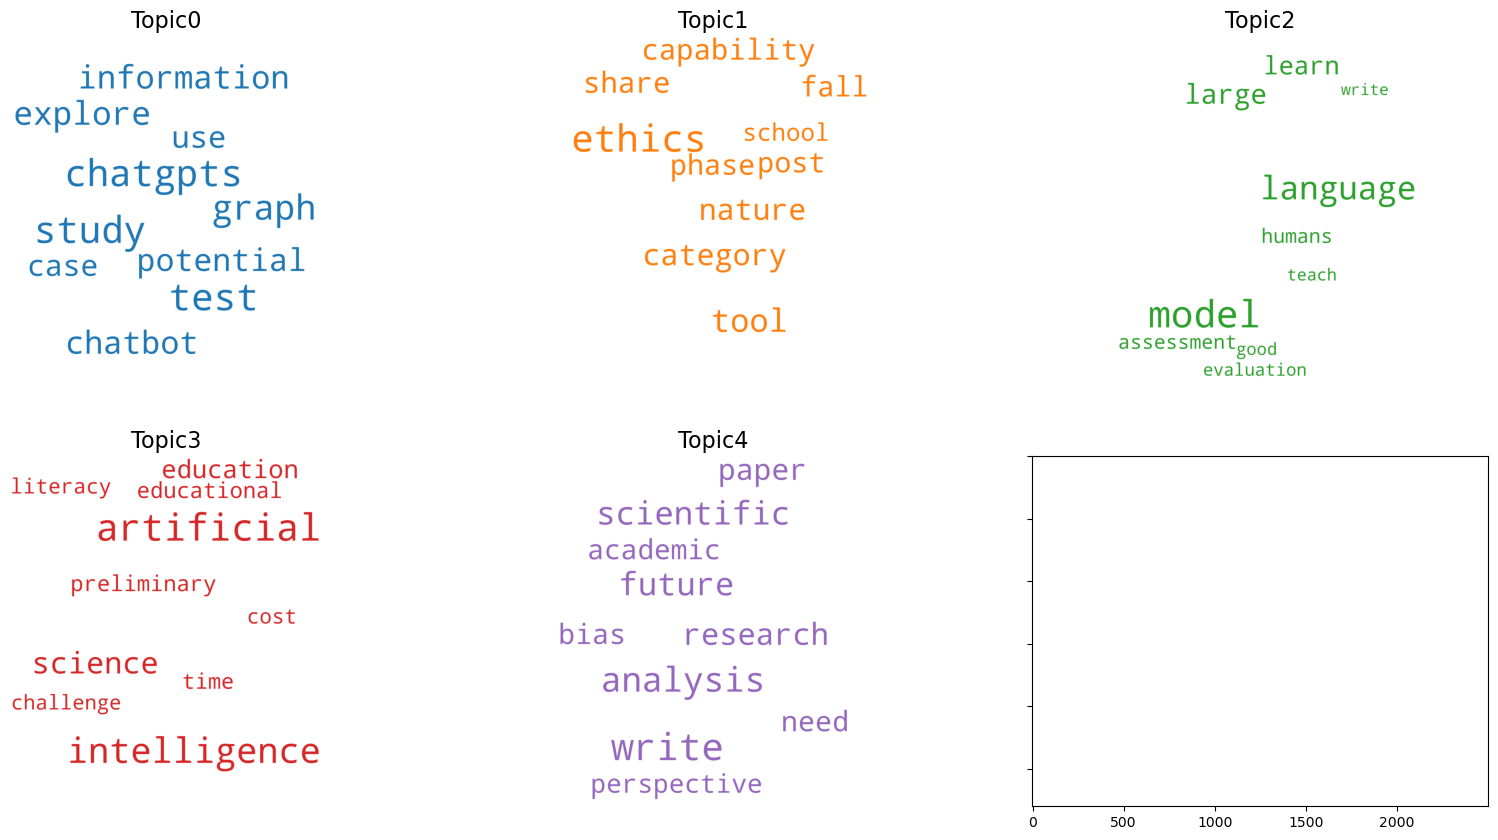

In [28]:
fig, axes = plt.subplots(2,3, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic' + str(i), fontdict = dict(size=16))
    plt.gca().axis('off')
    


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()




#### Topic Designation 

In [42]:
# print out paper titles to which the first topic (topic 0) has  considerable contribution

df= pd.read_csv("topic_titles_keywords-v2.csv")

first_topic_titles= df.loc[(df["Dominant_Topic"] == 0) & (df["Perc_Contribution"] > 0.9)].Title.to_list()

for title in first_topic_titles:
    print(title)
    print("----------------------------------------")

ChatGPT Makes Medicine Easy to Swallow: An Exploratory Case Study on Simplified Radiology Reports
----------------------------------------
Use of ChatGPT in Academic Publishing: A Rare Case of Seronegative Systemic Lupus Erythematosus in a Patient With HIV Infection
----------------------------------------
When Palliative Care May Be the Only Option in the Management of Severe Burns: A Case Report Written With the Help of ChatGPT
----------------------------------------
ChatGPT & Generative AI Systems as Quasi-Expert Legal Advice Lawyers-Case Study Considering Potential Appeal Against Conviction of Tom Hayes
----------------------------------------
" I think this is the most disruptive technology": Exploring Sentiments of ChatGPT Early Adopters using Twitter Data
----------------------------------------
What if the devil is my guardian angel: ChatGPT as a case study of using chatbots in education
----------------------------------------
Can chatgpt write a good boolean query for system

In [54]:
# print out paper titles to which the second topic (topic 1) has a considerable contribution 

first_topic_titles= df.loc[(df["Dominant_Topic"] == 1) & (df["Perc_Contribution"] > 0.88)].Title.to_list()

for title in first_topic_titles:
    print(title)
    print("----------------------------------------")

Assessing the Capabilities of ChatGPT to Improve Additive Manufacturing Troubleshooting
----------------------------------------
Generating Secure Hardware using ChatGPT Resistant to CWEs
----------------------------------------
Extraventricular neurocytoma of the posterior fossa: a case report written by ChatGPT
----------------------------------------
Can ChatGPT pass the life support exams without entering the American heart association course?
----------------------------------------
An era of ChatGPT as a significant futuristic support tool: A study on features, abilities, and challenges
----------------------------------------
ChatGPT Output Regarding Compulsory Vaccination and COVID-19 Vaccine Conspiracy: A Descriptive Study at the Outset of a Paradigm Shift in Online Search …
----------------------------------------
Evaluating the performance of chatgpt in ophthalmology: An analysis of its successes and shortcomings
----------------------------------------
Chinese Intermediate 

In [46]:
# print out paper titles to which the third topic (topic 2) has a considerable contribution

first_topic_titles= df.loc[(df["Dominant_Topic"] == 2) & (df["Perc_Contribution"] > 0.85)].Title.to_list()

for title in first_topic_titles:
    print(title)
    print("----------------------------------------")

How Well Does ChatGPT Do When Taking the Medical Licensing Exams? The Implications of Large Language Models for Medical Education and Knowledge …
----------------------------------------
How will Language Modelers like ChatGPT Affect Occupations and Industries?
----------------------------------------
How Close is ChatGPT to Human Experts? Comparison Corpus, Evaluation, and Detection
----------------------------------------
Better by You, better than Me? ChatGPT-3 as writing assistance in students' essays.
----------------------------------------
ChatGPT and other large language models are double-edged swords
----------------------------------------
A multitask, multilingual, multimodal evaluation of chatgpt on reasoning, hallucination, and interactivity
----------------------------------------
Is ChatGPT better than Human Annotators? Potential and Limitations of ChatGPT in Explaining Implicit Hate Speech
----------------------------------------
ChatGPT and antimicrobial advice: the en

In [53]:
# print out paper titles to which the fourth topic (topic 3) has a  considerable contribution

first_topic_titles= df.loc[(df["Dominant_Topic"] == 3) & (df["Perc_Contribution"] > 0.88)].Title.to_list()

for title in first_topic_titles:
    print(title)
    print("----------------------------------------")

A deeper dive into ChatGPT: History, use and future perspectives for orthopaedic research
----------------------------------------
Comparing scientific abstracts generated by ChatGPT to original abstracts using an artificial intelligence output detector, plagiarism detector, and blinded human …
----------------------------------------
The perception of Artificial Intelligence in educational contexts after the launch of ChatGPT: Disruption or Panic?
----------------------------------------
ChatGPT for higher education and professional development: A guide to conversational AI
----------------------------------------
Conversational AI-Powered Design: ChatGPT as Designer, User, and Product
----------------------------------------
Applicability of ChatGPT in assisting to solve higher order problems in pathology
----------------------------------------
Who Were the 10 Best and 10 Worst US Presidents? The Opinion of Chat GPT (Artificial Intelligence)
----------------------------------------


In [51]:
# print out paper titles to which the fifth (last) topic (topic 4) has  considerable contribution

first_topic_titles= df.loc[(df["Dominant_Topic"] == 4) & (df["Perc_Contribution"] > 0.85)].Title.to_list()

for title in first_topic_titles:
    print(title)
    print("----------------------------------------")

A computer wrote this paper: What chatgpt means for education, research, and writing
----------------------------------------
ChatGPT: the next frontier in academic writing for cardiologists or a pandora's box of ethical dilemmas
----------------------------------------
Chatbots, ChatGPT, and Scholarly Manuscripts-WAME Recommendations on ChatGPT and Chatbots in Relation to Scholarly Publications
----------------------------------------
Assessing the Value of ChatGPT for Clinical Decision Support Optimization
----------------------------------------
Transparency Guidance for ChatGPT Usage in Scientific Writing
----------------------------------------
Chat with ChatGPT on Interactive Engines for Intelligent Driving
----------------------------------------
Generative Pre-training Transformer Chat (ChatGPT) in the scientific community: The train has left the station
----------------------------------------
Let the devil speak for itself: Should ChatGPT be allowed or banned in hospitality a

### Topic Designation

In [47]:
topic_dict = {0: 'Potential Applications and Use Cases of ChatGPT',
              1: 'ChatGPT as Support Tool in Various Fields',
              2: 'Implications and Evaluation of ChatGPT',
              3: 'Potential and Limitations of ChatGPT in Education and Research',
              4: 'ChatGPT and Its Implications for Scientific Writing'}

### Visualizing Distribution of Topics by Papers

In [113]:
lda_model_final = gensim.models.ldamodel.LdaModel.load("models/titles-v2.model")
print("done")

done


In [114]:
# distribution of topics by documents
df_topic_distribution = df_topic_sents_keywords['Dominant_Topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Dominant_Topic', 'Num Documents']
df_topic_distribution.sort_values("Dominant_Topic")
df_topic_distribution.to_csv("topic_distribution.csv")

,Dominant_Topic,Num Documents
2,0,161
4,1,148
3,2,150
0,3,183
1,4,180


In [115]:
# visualizing distribution of topics by documents

# Create a ggplot object and specify the mapping
p = ggplot(df_topic_distribution, aes(x='Dominant_Topic', y='Num Documents', fill='Dominant_Topic'))

# Add a bar layer with identity stat
p + geom_bar(stat='identity') + \
    ggtitle('Distribution of Topics by Papers') + \
    xlab('Dominant Topic') + \
    ylab('Number of Papers') + \
    theme(plot_title=element_text(size=20, hjust=0.5))

In [116]:
print(df_topic_distribution['Dominant_Topic'].dtype)
print(df_topic_distribution['Dominant_Topic'].unique())

int64
[3 4 0 2 1]


In [117]:
df_topic_distribution['Dominant_Topic'] = df_topic_distribution['Dominant_Topic'].astype(int)
df_topic_distribution['Dominant_Topic'] = df_topic_distribution['Dominant_Topic'].apply(lambda x: topic_dict[x])


In [118]:
# visualizing distribution of topics by documents

# Create a ggplot object and specify the mapping
p = ggplot(df_topic_distribution, aes(x='Dominant_Topic', y='Num Documents', fill='Dominant_Topic'))

# Add a bar layer with identity stat
p + geom_bar(stat='identity') + \
    ggtitle('Distribution of Topics by Papers') + \
    xlab('Dominant Topic') + \
    theme(plot_title=element_text(size=20, hjust=-0.5),
           axis_text_x=element_blank()) +\
    scale_size_manual(values=[10])


### Display Topics for Each Paper

In [119]:
# a function that takes in a topic vector for a single document 
# and returns the manually assigned topic designations based on the topic_dict dictionary:

def display_topics(topic_vec, topic_dict):
    # topic_vec is a list of tuples, where each tuple contains a topic index and its corresponding weight
    # topic_dict is a dictionary with the topic index as the key and the manually assigned topic name as the value
    
    # sort the topic vector by weight in descending order
    sorted_topics = sorted(topic_vec, key=lambda x: x[1], reverse=True)
    
    # iterate over the sorted topics and print out their names based on the topic_dict
    for topic in sorted_topics:
        topic_index = topic[0]
        topic_weight = topic[1]
        if topic_weight > 0.0:
            topic_name = topic_dict.get(topic_index, "Unknown Topic")
            print("{:.2f}% {}".format(topic_weight*100, topic_name))


In [134]:
# get the topic distribution for the document using the LDA model
topic_vec = lda_model_final.get_document_topics(corpus)

# print the topic vector
print(topic_vec[0])


[(0, 0.020544248), (1, 0.12622398), (2, 0.813214), (3, 0.020009134), (4, 0.020008586)]


In [135]:
print(titles[0])
print("\n")

# call the display_topics function to show the topics of the first paper
display_topics(topic_vec[0],topic_dict)

ChatGPT and the Rise of Large Language Models: The New AI-Driven Infodemic Threat in Public Health


81.32% Implications and Evaluation of ChatGPT
12.62% ChatGPT as Support Tool in Various Fields
2.05% Potential Applications and Use Cases of ChatGPT
2.00% Potential and Limitations of ChatGPT in Education and Research
2.00% ChatGPT and Its Implications for Scientific Writing


### Getting the Most Relevant/Likely Topics for a Term

In [155]:
# the term you want to find topics for
term = "education"

# number of top topics to retrieve
k = 3

# get the topic distribution for the term
term_topics = lda_model_final.get_term_topics(term, minimum_probability=0.01)

# check if the list is empty
if not term_topics:
    print(f"No topics found for '{term}'")
else:
    # sort the topic distribution by weight in descending order
    sorted_term_topics = sorted(term_topics, key=lambda x: x[1], reverse=True)[:k]

    # map topic ids to topic names using your topic_dict
    top_topics = [(topic_dict[topic_id], weight) for topic_id, weight in sorted_term_topics]

    # print the top k topics for the term
    print(f"Top {k} topics for '{term}': {top_topics}")

Top 3 topics for 'education': [('Potential and Limitations of ChatGPT in Education and Research', 0.01912265), ('Potential Applications and Use Cases of ChatGPT', 0.01082147)]


In [159]:
# the term you want to find topics for
term = "education"

# number of top topics to retrieve
k = 3

# get the topic distribution for the term
term_topics = lda_model_final.get_term_topics(term)

# check if the list is empty
if not term_topics:
    print(f"No topics found for '{term}'")
else:
    # calculate the sum of all topic weights
    total_weight = sum([weight for topic_id, weight in term_topics])

    # sort the topic distribution by weight in descending order
    sorted_term_topics = sorted(term_topics, key=lambda x: x[1], reverse=True)[:k]

    # map topic ids to topic names using your topic_dict and calculate percentages
    top_topics = [(topic_dict[topic_id], weight/total_weight*100) for topic_id, weight in sorted_term_topics]

    # print the top k topics for the term with percentages
    print(f"Top {k} topics for '{term}':")
    for topic, percentage in top_topics:
        print(f"- {topic}: {percentage:.2f}%")


Top 3 topics for 'education':
- Potential and Limitations of ChatGPT in Education and Research: 63.86%
- Potential Applications and Use Cases of ChatGPT: 36.14%
